#Generiranje pokemona, 

##*Deep Convolutional GAN*

### tim Ksi

In [ ]:
!pip install git+https://github.com/tensorflow/docs

Clone the repository where the dataset is located 

In [1]:
!git clone https://github.com/marijetap/Tim-Ksi.git

Cloning into 'Tim-Ksi'...
remote: Enumerating objects: 748, done.
remote: Total 748 (delta 0), reused 0 (delta 0), pack-reused 748
Receiving objects: 100% (748/748), 210.65 MiB | 29.55 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (725/725), done.


In [52]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

# filesystem libraries
import os
from pathlib import Path
import time
from tqdm.notebook import tqdm, trange # displays progress bars

# plotting and image namipulation libraries
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors
import cv2
from PIL import Image, ImageEnhance
from IPython import display

# Load data

In [6]:
DATA_PATH = Path('Tim-Ksi/Pokemon')

In [9]:
IM_SIZE = 64
def load_data():
  """
  loads data from DATA_PATH to a numpy array of size 
  (num_images, IM_SIZE, IM_SIZE,3)
  """
  canvas = np.zeros((0,IM_SIZE, IM_SIZE, 3), 'float32')
    
  for p in tqdm(list(DATA_PATH.glob('*.jpg'))):
      img = cv2.imread(str(p))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, dsize=(IM_SIZE, IM_SIZE), interpolation = cv2.INTER_AREA)

      canvas = np.append(canvas, img[None,...].astype('float32'), axis=0)

  print(f"Loaded {canvas.shape[0]} training examples")
  return canvas

In [10]:
train_images_original = load_data()


Loaded 721 training examples


## Visualize original dataset

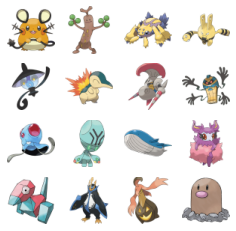

In [16]:
fig = plt.figure(figsize=(4, 4))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(train_images_original[i].astype(np.uint8))
  plt.axis('off')

## Expand dataset by adding some augmentation

In [17]:
def adjustContrast(x, range):
  img = Image.fromarray(x.astype(np.uint8))
  return np.array(ImageEnhance.Contrast(img).enhance(range))

def colorConvert(x, range):
  img = Image.fromarray(x.astype(np.uint8))
  return np.array(ImageEnhance.Color(img).enhance(range)) 

def shiftHue(x, i):
  hues = [(180-78)/360.0, (180-180)/360.0]
  hsv = matplotlib.colors.rgb_to_hsv(x)
  hsv[...,0]=hues[i]
  return matplotlib.colors.hsv_to_rgb(hsv)


In [18]:
train_images = np.append(
    train_images_original, 
    [
     list( map(lambda x: shiftHue(x, 0), train_images_original) ), 
     list( map(lambda x: shiftHue(x, 1), train_images_original) ), 
     list( map(lambda x: colorConvert(x, 2.5), train_images_original) ), 
     list( map(lambda x: colorConvert(x, 0.5), train_images_original) ), 
     list( map(lambda x: adjustContrast(x, 2), train_images_original) ),
    ]
    )

In [19]:
train_images = train_images.reshape(-1, IM_SIZE,IM_SIZE,3)

In [21]:
print(f"Final dataset has {train_images.shape[0]} images")

Final dataset has 4326 images


## Normalize the images to [-1, 1]

In [22]:
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

## Load the data into `tf.data.dataset` format

In [23]:
BUFFER_SIZE = 10 * len(train_images)
BATCH_SIZE = 128

Uncomment the first line (and comment the second) if you want to train on just one example

In [24]:
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).take(1).repeat(1024).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Define the generator model

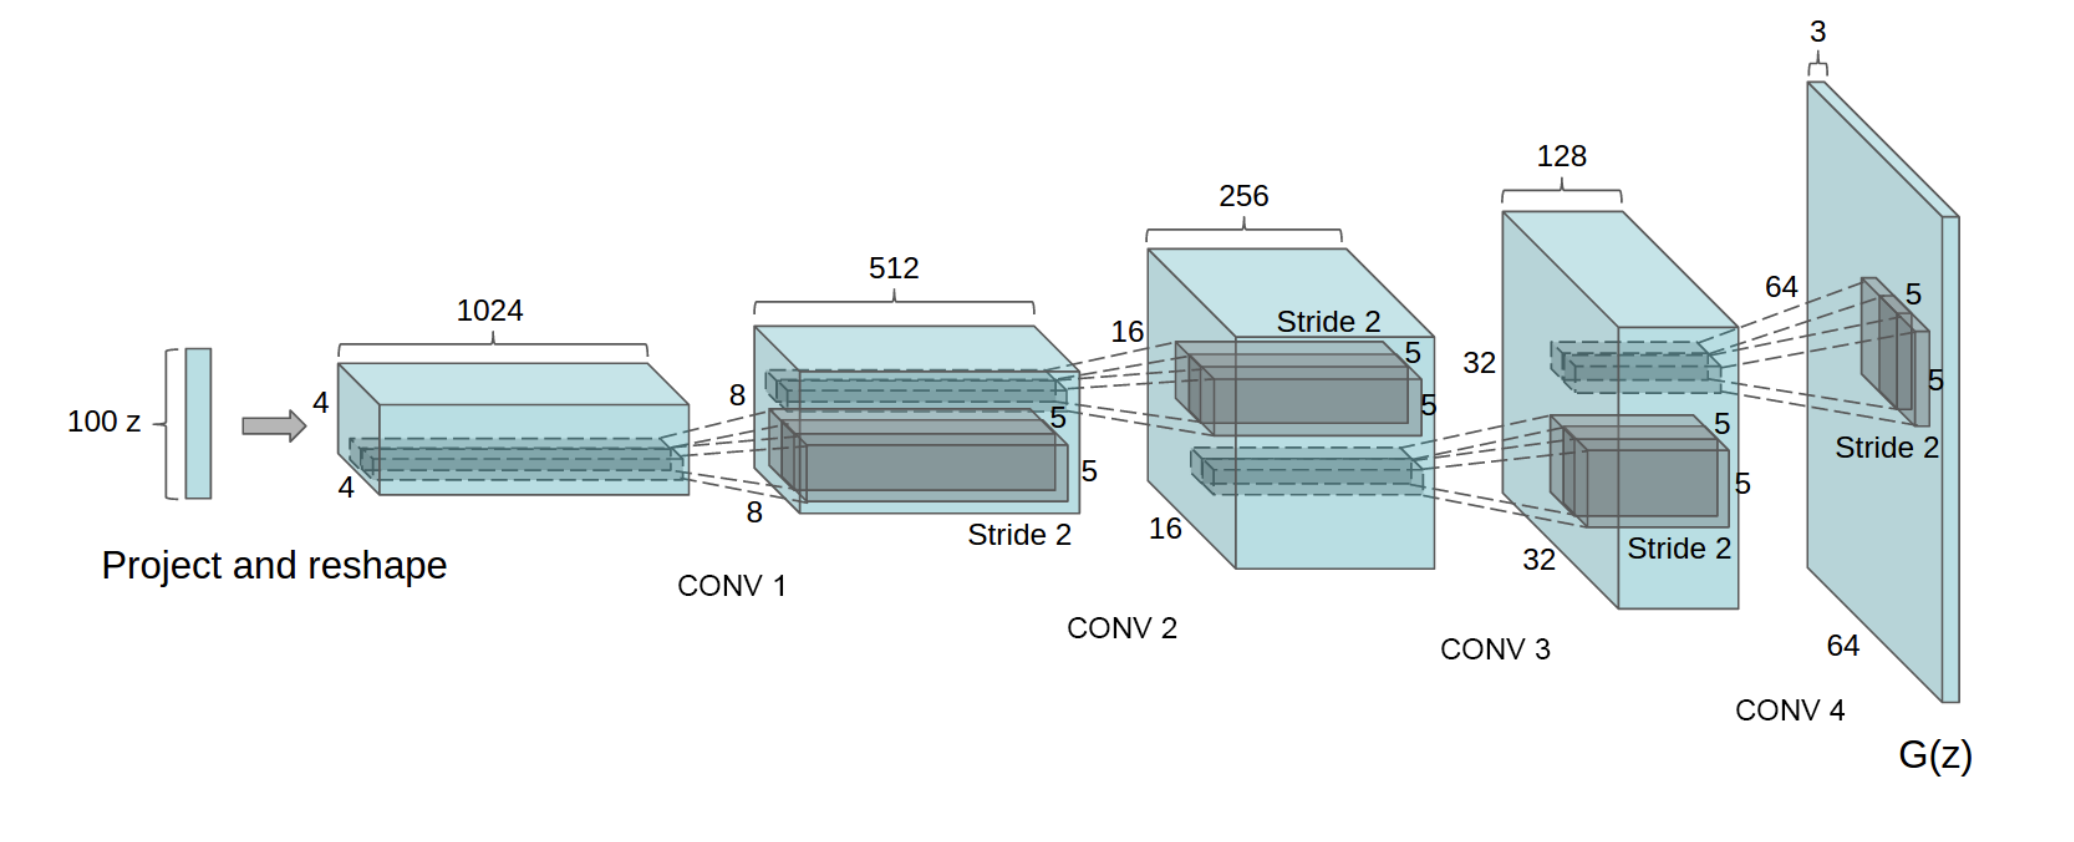

The generator model was originaly built to fit the image above, omitting the last BatchNorm layer greatly helped with convergence

In [59]:
noise_dim = 100 # To prevent mode collapse, the input to the generator model should be a random noise vector 

In [60]:
def make_generator_model():
    d = 64

    model = tf.keras.Sequential()

    model.add(layers.Dense( d * d * d // 16, input_shape=(noise_dim,)))
    model.add(layers.Reshape((d // 16, d // 16, d * 16)))

    model.add(layers.Conv2DTranspose(d * 8, 5, 2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    assert model.output_shape == (None, d // 8, d // 8, d * 8)

    model.add(layers.Conv2DTranspose(d * 4, 5, 2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    assert model.output_shape == (None, d // 4, d // 4, d * 4)

    model.add(layers.Conv2DTranspose(d * 2, 5, 2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    assert model.output_shape == (None, d // 2, d // 2, d * 2)

    model.add(layers.Conv2DTranspose(3, 5, 2, padding='same', use_bias=True, activation='tanh'))
    assert model.output_shape == (None, d, d, 3)

    return model

In [61]:
generator = make_generator_model()

Sample a random output on an untrained generator:

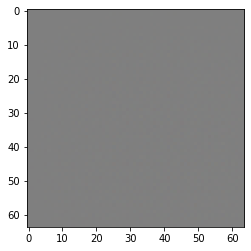

In [62]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

img = (generated_image[0, :, :].numpy() * 127.5 + 127.5)
plt.imshow(img.astype('uint8'))

Uncomment to see the plot of the model 

In [63]:
# tf.keras.utils.plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# Define discriminator model

![](https://github.com/abhiksingla/DCGAN-Pokemon/raw/master/structure_cnn.png)

The discriminator model was originaly built to fit the image above, omitting the first BatchNorm layer greatly helped with convergence

Data augmentation layers built into the discriminator model theoretically create an infinite dataeset. Every iteration a subset of augmentations (listed below) is randomly chosen (ant their parameters sampled from a continuous range). Having such a setup made the discriminator's task harder and enabled a better start to the generator in the early stages of learning.

In [64]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant', fill_value=1.0),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, fill_mode='constant', fill_value=1.0),
    ]
)


In [65]:
def make_discriminator_model():

    d = 64

    inputs = tf.keras.Input(shape=(d, d, 3))

    x = data_augmentation(inputs)
    x = layers.Conv2D(d, 3, 1, padding='same', use_bias=False)(x)
    # model.add(layers.BatchNormalization())
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(d, 5, 2, padding='same', use_bias=False)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(d * 2, 5, 2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(d * 4, 5, 2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(d * 8, 5, 2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((d * d * d // 32,))(x)
    outputs = layers.Dense(1)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")

In [66]:
discriminator = make_discriminator_model()

Discriminator output for random noise from the generator

In [67]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00120652]], shape=(1, 1), dtype=float32)


Uncomment to see the plot of the model 

In [68]:
# tf.keras.utils.plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

# Define losses and optimizers

### Discriminator loss

The discriminator has a binary task (determining whether an image is sampled from the real dataset (true distribution) or generated by the generator (fake distribution))

In [69]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [70]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

The generator learns to trick the generator. For every image in the fake output (output of the discriminator on fake images) the target verdict for the generator is 1.

In [71]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

As is the norm for training GANs we went fom Adam optimizer with `beta=0.5`.  

In [72]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Setup to enable checkpoints during training

In [73]:
!mkdir -p training_checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

In [74]:
# Each epoch display num_examples_to_generate for training visualization
num_examples_to_generate = 16  
# set a seed so that every epoch we check the images generated from the same latent vector  
seed = tf.random.normal([num_examples_to_generate, noise_dim]) 

# Track generator and discriminator losses during training
gen_loss_track=np.array([]) 
disc_loss_track=np.array([])

# For fine tuning the models (how hany epochs of training have already passed)
number_of_epochs_done=0

In [75]:
# Train step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(data_augmentation(images), training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

### Training function

For training visualization:

In [76]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False) # so all layers run in inference mode 
  
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :].numpy() * 127.5 + 127.5).astype('uint8'))
      plt.axis('off')

  # save the images every 10th epoch
  e = epoch//100
  if e%10==0: 
    !mkdir -p images/{e}
    plt.savefig(f'images/{e}/{epoch:04d}.png')
    plt.show()

In [77]:
def train(dataset, epochs, gen_loss_track, disc_loss_track, number_of_epochs_done):
  for epoch in range(epochs):
    start = time.time()
    
    progress_bar = tqdm(dataset, desc='', leave=True)
    
    for image_batch in progress_bar:
      gen_loss, disc_loss = train_step(image_batch)
      progress_bar.set_description(f"{gen_loss:.4f} {disc_loss:.4f}")
      
      gen_loss_track=np.append(gen_loss.numpy(),gen_loss)
      disc_loss_track=np.append(disc_loss.numpy(),disc_loss)

    # Every epoch, display the sample outputs from the generator
    display.clear_output(wait=True)
    generate_and_save_images(
        generator,
        epoch + 1 + number_of_epochs_done,
        seed
        )
    print ('Time for epoch {} is {} sec'.format(
        epoch + 1 + number_of_epochs_done, 
        time.time()-start)
    )

    # Start checkpoints after the 500th epoch 
    if epoch >500 and (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  # For the final outputs
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs + number_of_epochs_done,
                           seed)
  return gen_loss_track, disc_loss_track                      

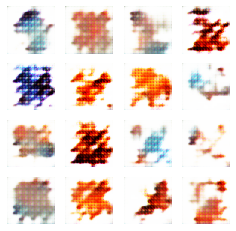

Time for epoch 26 is 18.10864496231079 sec


In [ ]:
EPOCHS=700
gen_loss_track, disc_loss_track = train(train_dataset, EPOCHS, gen_loss_track, disc_loss_track, 0)
number_of_epochs_done+=EPOCHS

(30600,)

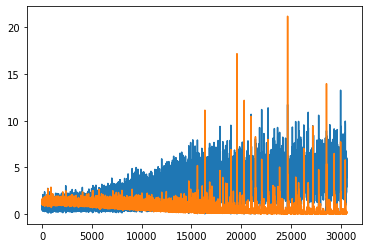

In [ ]:
plt.title(f"Generator and discriminator losses after {gen_loss_track.shape[0]} training steps")
plt.plot([i+1 for i in range(len(gen_loss_track))],gen_loss_track)
plt.plot([i+1 for i in range(len(disc_loss_track))],disc_loss_track)

In [ ]:
checkpoint.restore('training_checkpoints/ckpt-16') # example

# Visualize the training results

In [ ]:
generated_image=generator(tf.random.normal([2000, noise_dim]),training=False)
verdict=discriminator(generated_image, training=False)
top16 = verdict.numpy().argsort(axis=0)[-16:].reshape(-1)

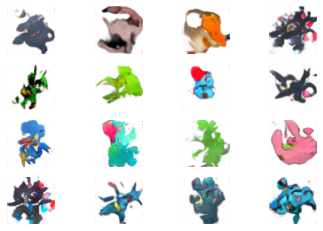

In [ ]:
plt. = plt.subplots(4,4)
for i in range(4):
  for j in range(4):
    ax[i][j].axis("off")
    ax[i][j].imshow(tf.cast(generated_image[top16[i*4+j],:,:,:]*127.5+127.5, tf.uint8))

## Traverse the latent space in a random direction

In [ ]:
rand_seed = tf.random.normal([1, noise_dim])
input = np.empty((100,100))

for i, alpha in zip(range(100), np.linspace(-1,1,100)):
  input[i,:] = rand_seed.numpy() * alpha

In [ ]:
outputs = generator(input)

In [ ]:
!rm latent/*

In [ ]:
for i, im in enumerate(outputs):
  fig, ax = plt.subplots()
  ax.axis("off")
  ax.imshow(tf.cast(im*127.5+127.5, tf.uint8))
  plt.savefig(f'latent/{i:04d}.png')

### Animate the images

In [ ]:
anim_file = 'latent.gif'

with imageio.get_writer(anim_file, mode='I', fps=5) as writer:
  filenames = Path('latent').glob('*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


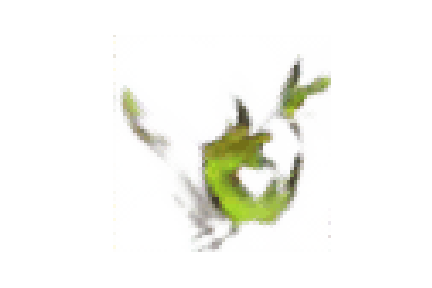

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)